<a href="https://colab.research.google.com/github/zuegereliane/python-intermediate-inflammation/blob/main/session3and4/group1_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 3 & 4
In the last session, you learned the basic processing steps for RNA sequencing data. Now you will do the next steps in the analysis of transcriptomics data. First, you will figure out which genes are up- or downregulated between two conditions using differential gene expression analysis. Then you will link this to biological pathways with Gene Ontology enrichment.

# Background

iPSCs are valuable resource to model drug interactions with different tissue and are frequenly used in drug screens to gain insights into drug specificity and toxicity. Tyrosine kinase inhibitors (TKIs) are important drugs in cancer treatment. Unfortunately, certain TKIs may lead to cardiomyopathy as a severe side effect of these drugs.

Here, you will compare the transcriptomes of iPSC-derived cardiomyocites treated with two different FDA-approved TKIs to investigate their toxicity and gain insights into the biological pathways potentially leading to cardiotoxicity.
- Doxorubicin
- Gefinitib

# Objectives

1. Explore the impact on global gene expression patterns (PCA).
2. Identify differentially expressed genes (DEGs) between mutant and WT for both drugs.
3. Visualized DEGs with volcano plots and heatmaps.
4. Perform GO enrichment to determine affected biological pathways.
5. Interpret the cardiotoxic potential of these drugs, and what cellular mechansims they might disrupt.


# Setup

Run the following cells to set up the necessary packages and download the data. If you wish to use a package which is not in the list below, you will need to install and import it yourself.


In [2]:
#Install packages which are not in the default environment
%pip install scanpy
%pip install pydeseq2
%pip install gseapy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 110.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.0/80.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 kB 15.2 MB/s eta 0:00:00


In [3]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import pickle
import gseapy


In [4]:
#Make data directory if it does not exist
os.makedirs("Session3and4/data", exist_ok=True)
os.makedirs("Session3and4/plots", exist_ok=True)

#Download datasets in the data folder

!wget https://raw.githubusercontent.com/LACDR-CDS/SCDR_Bioinformatics_Practical/refs/heads/main/Session3and4/data/counts_group1.txt -O Session3and4/data/counts_group1.txt
!wget https://raw.githubusercontent.com/LACDR-CDS/SCDR_Bioinformatics_Practical/refs/heads/main/Session3and4/data/metadata_group1.txt -O Session3and4/data/metadata_group1.txt


--2025-11-12 17:46:15--  https://raw.githubusercontent.com/LACDR-CDS/SCDR_Bioinformatics_Practical/refs/heads/main/Session3and4/data/counts_group1.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2773712 (2.6M) [text/plain]
Saving to: ‘Session3and4/data/counts_group1.txt’

Session3and4/data/c 100%[===================>]   2.64M  --.-KB/s    in 0.05s   

2025-11-12 17:46:15 (54.8 MB/s) - ‘Session3and4/data/counts_group1.txt’ saved [2773712/2773712]

--2025-11-12 17:46:15--  https://raw.githubusercontent.com/LACDR-CDS/SCDR_Bioinformatics_Practical/refs/heads/main/Session3and4/data/metadata_group1.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.co

# Preprocessing RNA seq data

Preprocess the data like you learned in the previous session.
- How many samples do you have?
- How many genes do you have before and after filtering?

In [5]:
count_table = pd.read_csv("Session3and4/data/counts_group1.txt", sep="\t", index_col = 0)
metadata_df = pd.read_csv("Session3and4/data/metadata_group1.txt", sep="\t", index_col = 0)

In [6]:
count_table.head()

,CTRL_1,CTRL_2,CTRL_3,CTRL_4,CTRL_5,CTRL_6,CTRL_7,CTRL_8,CTRL_9,CTRL_10,CTRL_11,CTRL_12,EPI_1,EPI_2,EPI_3,EPI_4,GEF_1,GEF_2,GEF_3,GEF_4
DDX11L1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
WASH7P,147,63,65,201,43,54,54,97,43,66,25,123,14,31,39,57,36,61,85,58
MIR6859-1,24,9,0,5,11,6,6,12,4,5,2,13,4,2,11,13,4,6,10,2
MIR1302-2HG,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
MIR1302-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
metadata_df.head()

,treatment,Concentration,cell_line,cell_type,replicate
CTRL_1,Control,0nM,MSN05,cardiomyocytes,1
CTRL_2,Control,0nM,MSN05,cardiomyocytes,2
CTRL_3,Control,0nM,MSN05,cardiomyocytes,3
CTRL_4,Control,0nM,MSN05,cardiomyocytes,4
CTRL_5,Control,0nM,MSN05,cardiomyocytes,5


# Principle component analysis (PCA)

Now explore your data with PCA like you did in the previous session.
- How do the different drug treatments impact global gene expression patterns?
- Which drug do you think has a stronger effect on gene expression?


In [13]:
gene_count_sums = count_table.sum(axis=1)


In [29]:
threshold = 10
print(f"Number of genes kept {sum(gene_count_sums >= threshold)} of {len(gene_count_sums)}")


Number of genes kept 31128 of 42844


In [30]:
filtered_count_table= count_table[gene_count_sums >= threshold]


In [32]:
#Normalization for PCA
total_reads = filtered_count_table.sum(axis = 0)
normalized_count_table = (filtered_count_table / total_reads) * 1000000
log_transformed_counts = np.log2(normalized_count_table + 1)

In [33]:
# PCA
scaler = StandardScaler()
scaled_table = scaler.fit_transform(log_transformed_counts.T)

pca = PCA()
pca_result_matrix= pca.fit_transform(scaled_table)
np.shape(pca_result_matrix)


(20, 20)

In [35]:
plot_df = pd.DataFrame({

"PC1": pca_result_matrix[:, 0],

"PC2": pca_result_matrix[:, 1],

"condition": metadata_df["treatment"].values

})

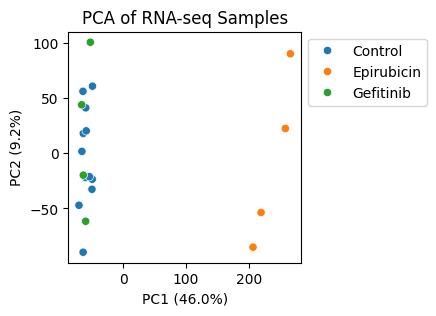

In [37]:
plt.figure(figsize=(3, 3))
sns.scatterplot(
data=plot_df,
x="PC1", y="PC2",
hue="condition"
)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")

plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")

plt.title("PCA of RNA-seq Samples")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

# Differential gene expression

Now you can perform differential gene expression analysis using the DEseq2 method. You will need to do this twice, comparing each drug with the untreated control condition. Make sure you use the raw counts for this (not the counts per million normalized counts used for PCA), since DEseq does it's own internal normalization method.
- First, you need to filter your count table and metadata to only contain the samples you want to compare. Here's an example of how to do this. Replace the ... with the drug name.

```
drug = "..."  

# Filter metadata to contain only drug and control
metadata_df_filtered = metadata_df[metadata_df["treatment"].isin([drug, "Control"])]
# Filter count table by matching index with the filtered metadata
counts_filtered = counts[metadata_df_filtered.index]
```
- Use the filtered data to create a DESeq object, and run the DEseq analysis based on the code cheat sheet.
- Look at the results of you analysis. What information do the rows and columns of the DEseq result mean.
- Now get the upregulated and downregulated genes from this dataframe. What does it mean for a gene to be up-/downregulated?
- Plot the results in a volcano plot. How many genes are differentially expressed?
- Repeat the analysis for the second drug. Are there more or less differentially expressed genes? Does this match your expectiations from the PCA analysis?


In [45]:
############ Epirubicin vs CTRL

drug = "Epirubicin"


# DEseq
metadata_df_filtered_epi = metadata_df[metadata_df["treatment"].isin([drug, "Control"])]
counts_filtered_epi = filtered_count_table[metadata_df_filtered_epi.index]

# Create DESeq2 object
deseq_object = DeseqDataSet(
    counts=counts_filtered_epi.T,
    metadata=metadata_df_filtered_epi,
    design_factors="treatment",
)

# Run DESeq2
deseq_object.deseq2()

# Get results for the current contrast
stat_res_epi = DeseqStats(deseq_object, contrast=("treatment", "Epirubicin", "Control"))
stat_res_epi.summary()
results_df_epi = stat_res_epi.results_df

/tmp/ipython-input-1134075122.py:11: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  deseq_object = DeseqDataSet(
Fitting size factors...
... done in 0.05 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 48.57 seconds.

Fitting dispersion trend curve...
... done in 0.87 seconds.

Fitting MAP dispersions...
... done in 68.49 seconds.

Fitting LFCs...
... done in 32.10 seconds.

Calculating cook's distance...
... done in 0.04 seconds.

Replacing 81 outlier genes.

Fitting dispersions...
... done in 0.16 seconds.

Fitting MAP dispersions...
... done in 0.16 seconds.

Fitting LFCs...
... done in 0.18 seconds.

Running Wald tests...
... done in 10.26 seconds.



Log2 fold change & Wald test p-value: treatment Epirubicin vs Control
                   baseMean  log2FoldChange     lfcSE      stat        pvalue  \
WASH7P            57.697526       -0.239465  0.275257 -0.869969  3.843176e-01   
MIR6859-1          6.930263        0.759671  0.556830  1.364278  1.724800e-01   
LOC124900384       4.885853       -0.117045  0.650522 -0.179925  8.572111e-01   
LOC729737        347.331812       -0.454060  0.282178 -1.609125  1.075890e-01   
DDX11L17           1.320788        4.873385  1.844827  2.641649  8.250358e-03   
...                     ...             ...       ...       ...           ...   
ND5           149899.052391        0.651489  0.355072  1.834811  6.653363e-02   
ND6            55832.116528        0.506917  0.418606  1.210967  2.259082e-01   
TRNE               0.353499       -0.735206  3.016669 -0.243714  8.074520e-01   
CYTB          174637.330653        0.787430  0.411836  1.912000  5.587625e-02   
TRNP            3277.564796        3.46

In [46]:
# Get upregulated and downregulated genes
upregulated_genes_epi = results_df_epi[
    (results_df_epi["log2FoldChange"] > 2) & (results_df_epi["padj"] < 0.05)
]
downregulated_genes_epi = results_df_epi[
    (results_df_epi["log2FoldChange"] < -2) & (results_df_epi["padj"] < 0.05)
]
print(f"    Upregulated genes: {upregulated_genes_epi.shape[0]}")
print(f"    Downregulated genes: {downregulated_genes_epi.shape[0]}")

    Upregulated genes: 8189
    Downregulated genes: 963


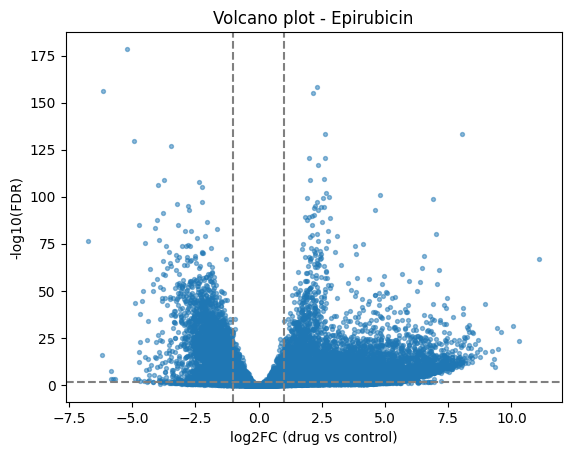

In [47]:
plt.scatter(
    results_df_epi.log2FoldChange, -np.log10(results_df_epi.padj), s=8, alpha=0.5
)
plt.axhline(-np.log10(0.05), ls="--", color="grey")
plt.axvline(1, ls="--", color="grey")
plt.axvline(-1, ls="--", color="grey")
plt.xlabel("log2FC (drug vs control)")
plt.ylabel("-log10(FDR)")
plt.title(f"Volcano plot - {drug}")
plt.show()



In [48]:
########### Gefinitib vs CTRL

drug = "Gefitinib"

metadata_df_filtered_gef = metadata_df[metadata_df["treatment"].isin([drug, "Control"])]
counts_filtered_gef = filtered_count_table[metadata_df_filtered_gef.index]

# Create DESeq2 object
deseq_object = DeseqDataSet(
    counts=counts_filtered_gef.T,
    metadata=metadata_df_filtered_gef,
    design_factors="treatment",
)

# Run DESeq2
deseq_object.deseq2()

# Get results for the current contrast
stat_res_gef = DeseqStats(deseq_object, contrast=("treatment", "Gefitinib", "Control"))
stat_res_gef.summary()
results_df_gef = stat_res_gef.results_df

/tmp/ipython-input-3984275824.py:9: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  deseq_object = DeseqDataSet(
Fitting size factors...
... done in 0.03 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 44.96 seconds.

Fitting dispersion trend curve...
... done in 0.84 seconds.

Fitting MAP dispersions...
... done in 55.44 seconds.

Fitting LFCs...
... done in 31.80 seconds.

Calculating cook's distance...
... done in 0.04 seconds.

Replacing 184 outlier genes.

Fitting dispersions...
... done in 0.32 seconds.

Fitting MAP dispersions...
... done in 0.37 seconds.

Fitting LFCs...
... done in 0.30 seconds.

Running Wald tests...
... done in 10.10 seconds.



Log2 fold change & Wald test p-value: treatment Gefitinib vs Control
                   baseMean  log2FoldChange     lfcSE      stat    pvalue  \
WASH7P            67.989688        0.209970  0.244124  0.860094  0.389737   
MIR6859-1          6.570236        0.087220  0.556917  0.156612  0.875551   
LOC124900384       5.252381       -0.453242  0.597918 -0.758034  0.448431   
LOC729737        392.398424       -0.240470  0.246154 -0.976908  0.328615   
DDX11L17           0.036114        0.295672  3.849808  0.076802  0.938781   
...                     ...             ...       ...       ...       ...   
ND5           153381.449154        0.362097  0.373796  0.968702  0.332694   
ND6            61270.934214        0.531070  0.514661  1.031884  0.302126   
TRNE               0.576040        0.264482  1.869595  0.141465  0.887503   
CYTB          173670.016579        0.382910  0.425466  0.899979  0.368131   
TRNP            1076.775011        0.281788  0.348541  0.808479  0.418815   

      

In [49]:
# Get upregulated and downregulated genes
upregulated_genes_gef = results_df_gef[
    (results_df_gef["log2FoldChange"] > 2) & (results_df_gef["padj"] < 0.05)
]
downregulated_genes_gef = results_df_gef[
    (results_df_gef["log2FoldChange"] < -2) & (results_df_gef["padj"] < 0.05)
]
print(f"    Upregulated genes: {upregulated_genes_gef.shape[0]}")
print(f"    Downregulated genes: {downregulated_genes_gef.shape[0]}")

    Upregulated genes: 0
    Downregulated genes: 10


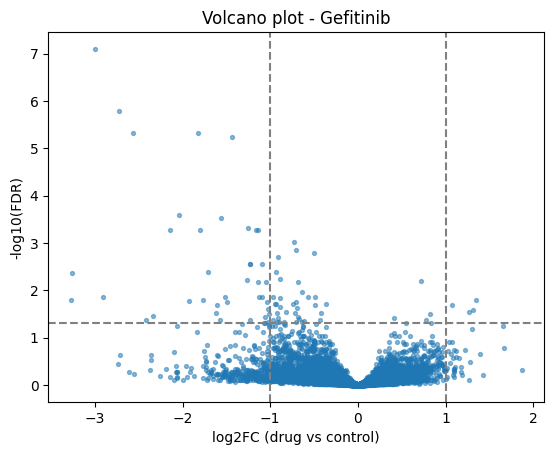

In [50]:
plt.scatter(
    results_df_gef.log2FoldChange, -np.log10(results_df_gef.padj), s=8, alpha=0.5
)
plt.axhline(-np.log10(0.05), ls="--", color="grey")
plt.axvline(1, ls="--", color="grey")
plt.axvline(-1, ls="--", color="grey")
plt.xlabel("log2FC (drug vs control)")
plt.ylabel("-log10(FDR)")
plt.title(f"Volcano plot - {drug}")
plt.show()



# Gene Ontology enrichment

Now, you can start interpreting the lists of genes you get from the DEseq analysis and learn if there are any biological pathways that are effected by the drug treatment.
- Use the cheat sheet to perform a GO enrichment analysis on the upregulated and dowregulated genes of each drug treatment. Which pathways can you see?
- Based on this analysis, do you think either of the drugs you tested are cardiotoxic? Which cellular mechanisms do they disrupt?

In [51]:
GO_databases = [
    "GO_Biological_Process_2025",
    "GO_Cellular_Component_2025",
    "GO_Molecular_Function_2025",
]

In [53]:
import time

In [54]:
########## Epirubicin

go_upr_results_epi = {}
go_dwr_results_epi = {}

for db in GO_databases:
    try:
        print(f"    {db}")

        # Upregulated genes
        enr_upr = gseapy.enrichr(
            gene_list=upregulated_genes_epi.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_upr_results_epi[db] = enr_upr.res2d

        # Downregulated genes
        enr_dwr = gseapy.enrichr(
            gene_list=downregulated_genes_epi.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_dwr_results_epi[db] = enr_dwr.res2d

    except Exception as e:
        time.sleep(30)  # Wait longer if there's an error

    GO_Biological_Process_2025
    GO_Cellular_Component_2025
    GO_Molecular_Function_2025


In [55]:


print(go_upr_results_epi)
print(go_dwr_results_epi)



{'GO_Biological_Process_2025':                         Gene_set  \
0     GO_Biological_Process_2025   
1     GO_Biological_Process_2025   
2     GO_Biological_Process_2025   
3     GO_Biological_Process_2025   
4     GO_Biological_Process_2025   
...                          ...   
4410  GO_Biological_Process_2025   
4411  GO_Biological_Process_2025   
4412  GO_Biological_Process_2025   
4413  GO_Biological_Process_2025   
4414  GO_Biological_Process_2025   

                                                   Term Overlap   P-value  \
0       Intermediate Filament Organization (GO:0045109)   43/72  0.000984   
1     Ag Processing and Presentation of Endogenous P...   11/13  0.001650   
2     Ag Processing and Presentation of Endogenous P...   11/13  0.001650   
3     Antigen Processing and Presentation of Endogen...   11/13  0.001650   
4     Antigen Processing and Presentation of Peptide...   11/13  0.001650   
...                                                 ...     ...       ... 

In [56]:
for k, v in go_upr_results_epi.items():
    if v is not None:
        print(f"{k}: {v.shape}")

        try:
            gseapy.plot.dotplot(
                v,
                title=f"{k[0], k[1]} \n {k[2]} \n Upregulated pathways \n ",  # Figure title
                cmap="flare",  # Color map
                # top_term=10,  # Number of top terms to show
                # size=5,  # Dot size
                # figsize=(6, 6),  # Figure size (width, height)
                # ofname="dotplot_GO_Biological_Process_2025.png",  # Save figure to file (optional)
            )
            # plt.savefig("dotplot_GO_Biological_Process_2025.png", bbox_inches="tight")
            # plt.show()

        except Exception as e:
            print(f"Error occurred while plotting {k}: {e}")

    else:
        print(f"{k}: None")

GO_Biological_Process_2025: (4415, 10)
Error occurred while plotting GO_Biological_Process_2025: Warning: No enrich terms when cutoff = 0.05
GO_Cellular_Component_2025: (353, 10)
Error occurred while plotting GO_Cellular_Component_2025: Warning: No enrich terms when cutoff = 0.05
GO_Molecular_Function_2025: (910, 10)
Error occurred while plotting GO_Molecular_Function_2025: Warning: No enrich terms when cutoff = 0.05


GO_Biological_Process_2025: (2612, 10)
GO_Cellular_Component_2025: (258, 10)
GO_Molecular_Function_2025: (519, 10)


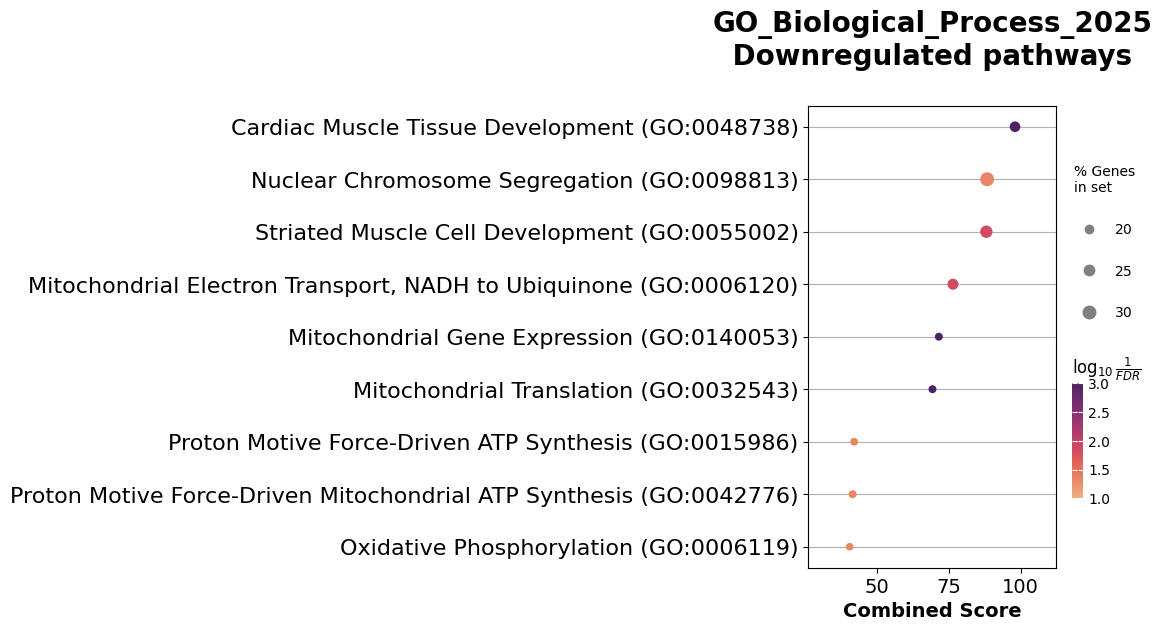

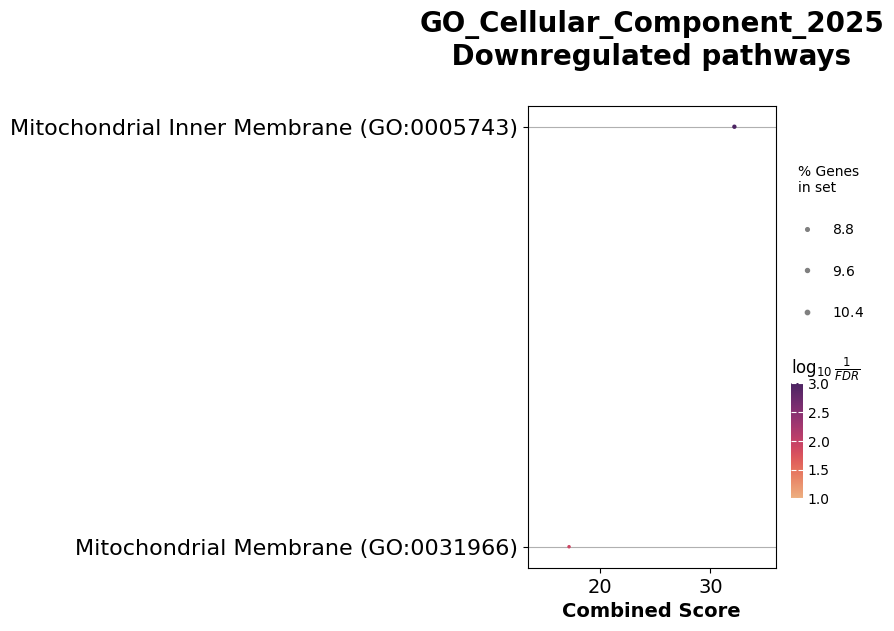

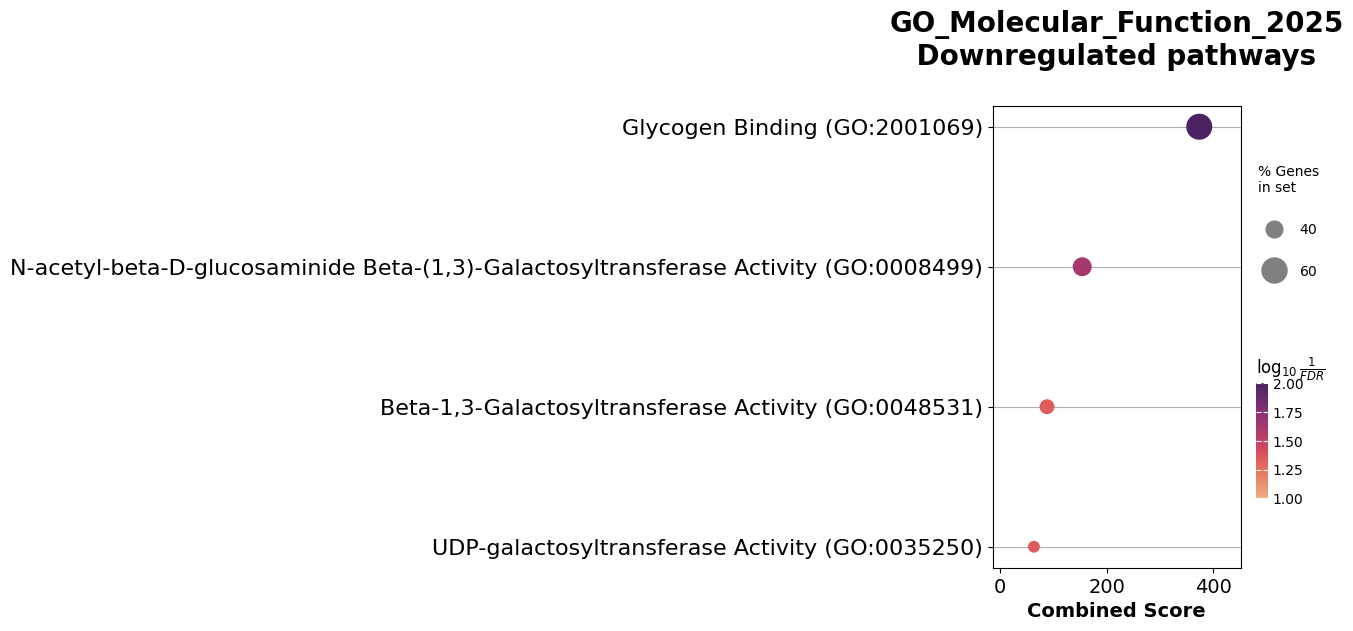

In [57]:
for k, v in go_dwr_results_epi.items():
    if v is not None:
        print(f"{k}: {v.shape}")

        try:
            gseapy.plot.dotplot(
                v,
                title=f"{k}\n Downregulated pathways \n ",  # Figure title
                cmap="flare",  # Color map
                top_term=10,  # Number of top terms to show
                # size=5,  # Dot size
                # figsize=(6, 6),  # Figure size (width, height)
                # ofname="dotplot_GO_Biological_Process_2025.png",  # Save figure to file (optional)
            )
            # plt.savefig("dotplot_GO_Biological_Process_2025.png", bbox_inches="tight")
            # plt.show()

        except Exception as e:
            print(f"Error occurred while plotting {k}: {e}")

    else:
        print(f"{k}: None")

In [58]:
########### Genifitib


go_upr_results_gef = {}
go_dwr_results_gef = {}

for db in GO_databases:
    try:
        print(f"    {db}")

        # Upregulated genes
        enr_upr = gseapy.enrichr(
            gene_list=upregulated_genes_gef.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_upr_results_gef[db] = enr_upr.res2d

        # Downregulated genes
        enr_dwr = gseapy.enrichr(
            gene_list=downregulated_genes_gef.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_dwr_results_gef[db] = enr_dwr.res2d

    except Exception as e:
        time.sleep(30)  # Wait longer if there's an error

    GO_Biological_Process_2025
    GO_Cellular_Component_2025
    GO_Molecular_Function_2025


In [59]:


print(go_upr_results_gef)
print(go_dwr_results_gef)



{}
{}
